In [1]:
# import functions
from time import time
import pandas as pd
import numpy as np
import math
import sys

# import hand-craft functions from the file utils
import utils.mydata as mydata # all data preprocessing functions stored in mydata.py
from utils.util_fun import evaluate
from utils.feature_map import feature_map
from utils.layerobject import ConvLayer, Activation, PoolingLayer, FC, SMLayer

In [2]:
# LeNet5 object (modified version)
class LeNet5_update(object):
    def __init__(self, activate= "ELU", init_mode = "Xavier"):
        # define kernel shape of each layer
        kernel_shape = {"C1": (3,3,3,6),
                        "C2": (3,3,6,16),
                        "C3": (3,3,16,30), 
                        
                        "C5": (3,3,30,120), ### It's actually a FC layer
                        
                        "F7": (120,84),
                        "F8": (84,50)}      
        # apply ELU activation
        activate = activate
        
        # Conv1 -> ELU -> average pooling 1
        hparameters_convlayer = {"stride": 3, "pad": 1}
        hparameters_pooling   = {"stride": 3, "f": 3}        
        self.C1 = ConvLayer(kernel_shape["C1"], hparameters_convlayer, init_mode)
        # output of C1 is n X 84X84X6
        self.a1 = Activation(activate) 
        self.S1 = PoolingLayer(hparameters_pooling, "average")
        # output of S1 is n X 28X28X6
        
        # Conv2 -> ELU -> average pooling 2
        hparameters_convlayer = {"stride": 1, "pad": 0}
        hparameters_pooling   = {"stride": 2, "f": 2}
        self.C2 = ConvLayer(kernel_shape["C2"], hparameters_convlayer, init_mode)
        # output of C2 is n X 26X26X16
        self.a2 = Activation(activate) 
        self.S2 = PoolingLayer(hparameters_pooling, "average")        
        # output of S2 is n X 13X13X16
        
        # Conv3 -> ELU -> average pooling 3
        hparameters_convlayer = {"stride": 2, "pad": 0}
        hparameters_pooling   = {"stride": 2, "f": 2}
        self.C3 = ConvLayer(kernel_shape["C3"], hparameters_convlayer, init_mode)
        # output of C3 is n X 6X6X30
        self.a3 = Activation(activate) 
        self.S3 = PoolingLayer(hparameters_pooling, "average")
        # output of S3 is n X 3X3X30
        
        # flatten
        hparameters_convlayer = {"stride": 2, "pad": 0}
        self.C5 = ConvLayer(kernel_shape["C5"], hparameters_convlayer, init_mode)
        self.a6 = Activation(activate)
        # output of a6 is n X 1 X 1 X 120
        
        # FC1
        self.F7 = FC(kernel_shape["F7"], init_mode)
        self.a7 = Activation(activate)
        # output of a7 is n X 84 
        
        # FC2 + softmax
        self.F8 = FC(kernel_shape["F8"], init_mode)
        self.Output = SMLayer()
        # output of output is n X 50
        
    def Forward_Propagation(self, input_image, input_label, mode): 
        # INPUT onehot labels
        self.label = input_label
        self.C1_FP = self.C1.foward_prop(input_image)
        self.a1_FP = self.a1.foward_prop(self.C1_FP)
        self.S1_FP = self.S1.foward_prop(self.a1_FP)
        
        self.C2_FP = self.C2.foward_prop(self.S1_FP)
        self.a2_FP = self.a2.foward_prop(self.C2_FP)
        self.S2_FP = self.S2.foward_prop(self.a2_FP)
        
        self.C3_FP = self.C3.foward_prop(self.S2_FP)
        self.a3_FP = self.a3.foward_prop(self.C3_FP)
        self.S3_FP = self.S3.foward_prop(self.a3_FP)
                     
        self.C5_FP = self.C5.foward_prop(self.S3_FP)
        self.a6_FP = self.a6.foward_prop(self.C5_FP)
        
        # output of a6 is n X 1 X 1 X 120
        self.flatten = self.a6_FP[:,0,0,:]
        self.F7_FP = self.F7.foward_prop(self.flatten)
        self.a7_FP = self.a7.foward_prop(self.F7_FP)
        
        self.F8_FP = self.F8.foward_prop(self.a7_FP)
        
        # output sum of the loss of the mini-batch when mode = 'train'
        # output predicted class when mode = 'test'        
        out  = self.Output.foward_prop(self.F8_FP, input_label, mode) 
        return out 
        
    def Back_Propagation(self, momentum, weight_decay):
        dy_pred = self.Output.back_prop()
        dy_pred = self.F8.back_prop(dy_pred, momentum, weight_decay)
        dy_pred = self.a7.back_prop(dy_pred)
        F7_BP = self.F7.back_prop(dy_pred, momentum, weight_decay)
        # reshape gradient back to nX1X1X120
        reverse_flatten = F7_BP[:,np.newaxis,np.newaxis,:]
        
        reverse_flatten = self.a6.back_prop(reverse_flatten) 
        C5_BP = self.C5.back_prop(reverse_flatten, momentum, weight_decay)       
        
        S3_BP = self.S3.back_prop(C5_BP)
        S3_BP = self.a3.back_prop(S3_BP)
        C3_BP = self.C3.back_prop(S3_BP, momentum, weight_decay)
        
        S2_BP = self.S2.back_prop(C3_BP)
        S2_BP = self.a2.back_prop(S2_BP)
        C2_BP = self.C2.back_prop(S2_BP, momentum, weight_decay)
        
        S1_BP = self.S1.back_prop(C2_BP)
        S1_BP = self.a1.back_prop(S1_BP)  
        self.C1.back_prop(S1_BP, momentum, weight_decay)        
   
    def set_learning_rate(self, lr_global):
        # set learning rate of all layer to be the same
        self.C1.learning(lr_global)
        self.S1.learning(lr_global)
        self.C2.learning(lr_global)
        self.S2.learning(lr_global)
        self.C3.learning(lr_global)
        self.S3.learning(lr_global)
        self.C5.learning(lr_global)
        self.F7.learning(lr_global)
        self.F8.learning(lr_global)
        self.Output.learning(lr_global)

---------- epoch 1 begin ----------
global learning rate: 5e-06
learning rates in trainable layers: [5.e-06 5.e-06 5.e-06 5.e-06 5.e-06]
batch size: 500
Momentum: 0.95 , weight decay: 0
Done, cost of epoch 1 : 246186.772208195                                              
Top1 accuracy of training set: 3.3225424397947094 %
Top1 accuracy of validation set:  2.666666666666667 %
Time used:  1504.7192070484161 sec
---------- epoch 1 end ------------
Feature maps of C1
Feature maps of S1
Feature maps of S2
---------- epoch 2 begin ----------
global learning rate: 5e-06
learning rates in trainable layers: [5.e-06 5.e-06 5.e-06 5.e-06 5.e-06]
batch size: 500
Momentum: 0.95 , weight decay: 0
Done, cost of epoch 2 : 244193.77799016237                                              
Top1 accuracy of training set: 4.577970785629688 %
Top1 accuracy of validation set:  3.3333333333333335 %
Time used:  1551.9278106689453 sec
---------- epoch 2 end ------------
---------- epoch 3 begin ----------
globa

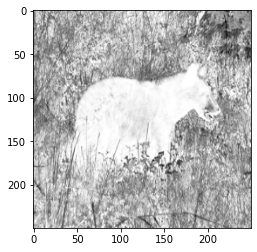

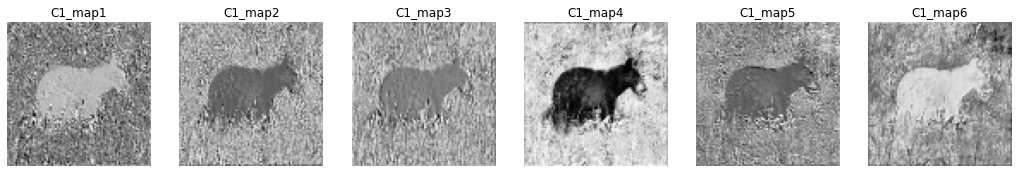

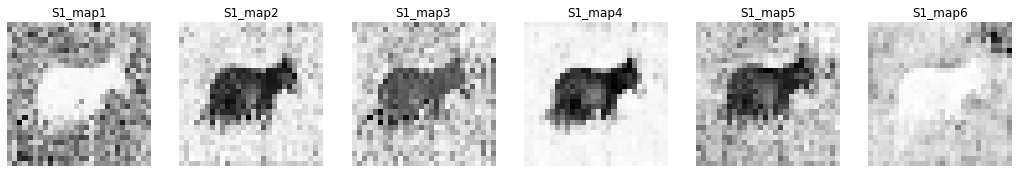

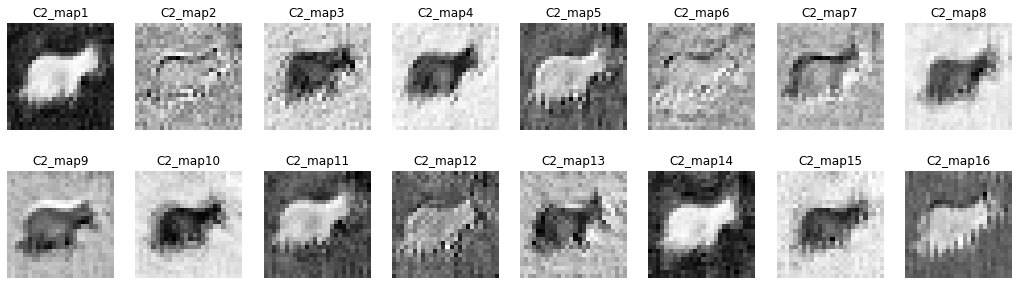

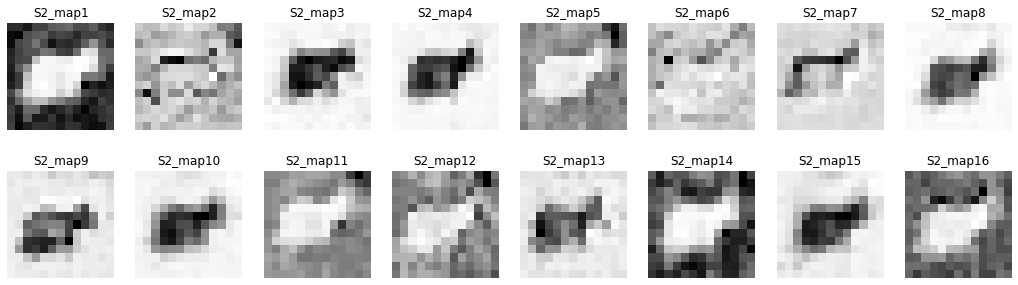

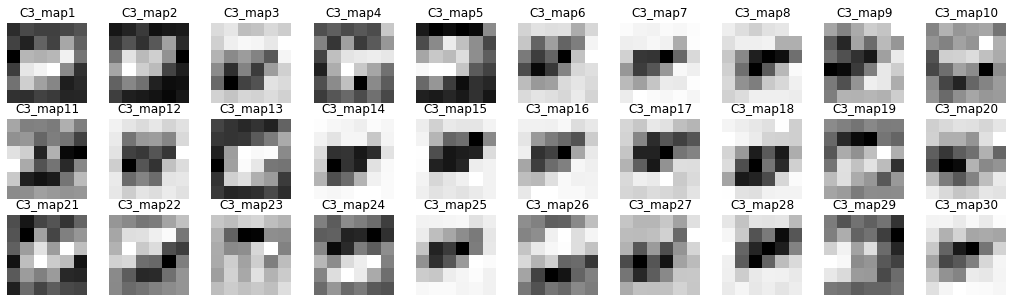

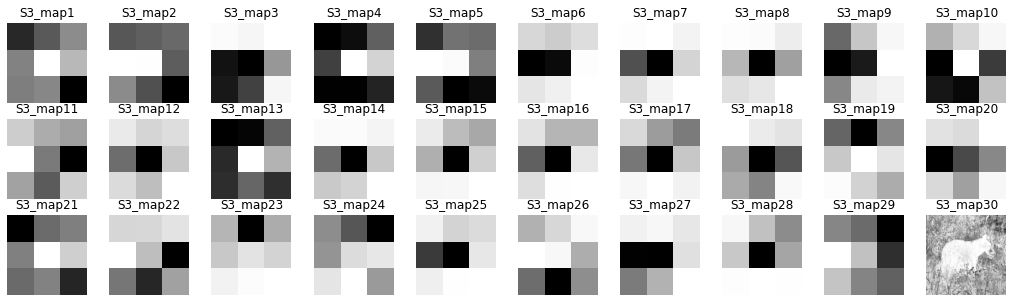

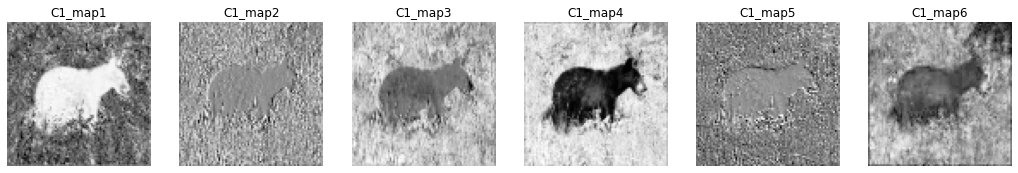

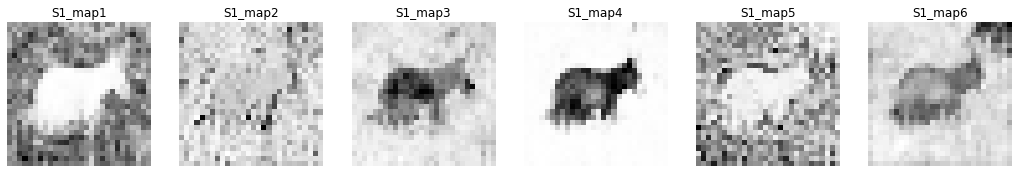

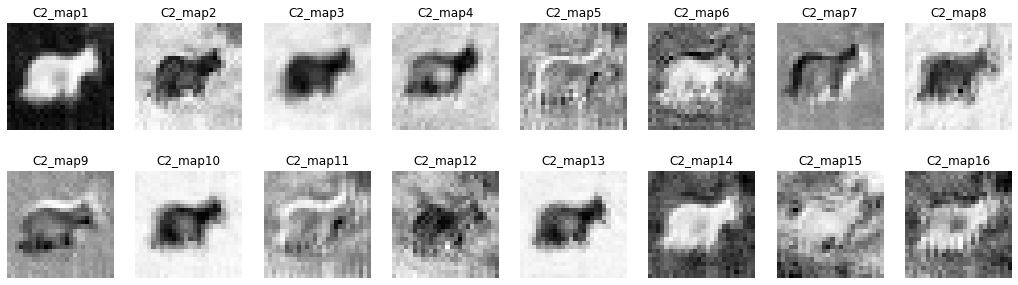

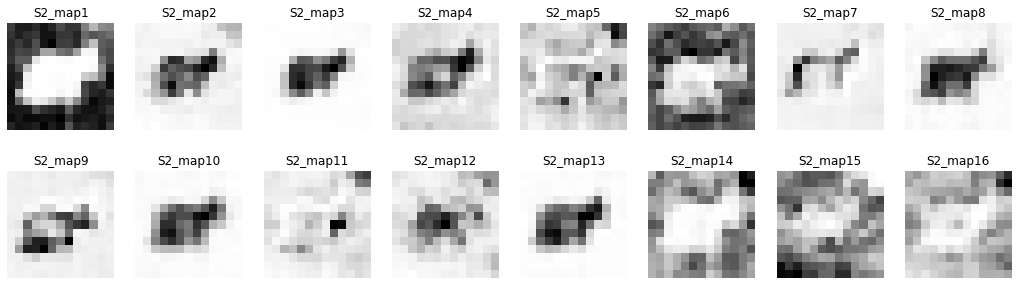

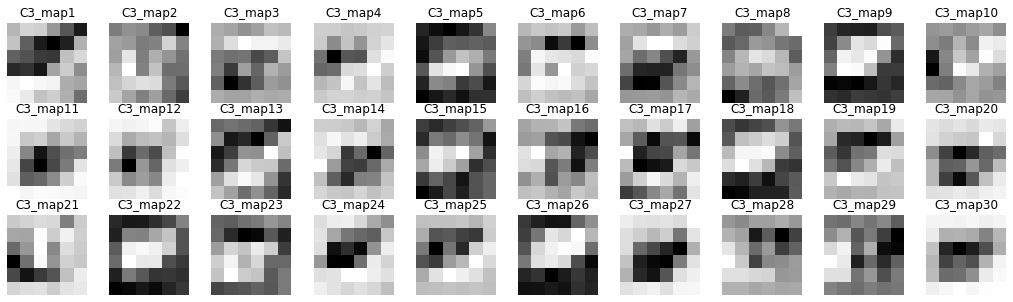

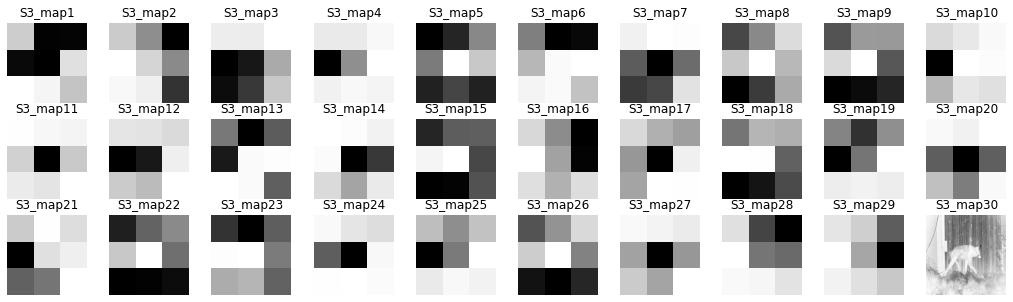

In [3]:
# just for reference, as the data is pre-read, cannnot changing number only here
    batch_size = 500
    # set normalize mode n1p1, that normalize batch of data into range [-1,1]
    normalize_mode = 'n1p1'
    
    # -----------------------Reference information-------------------#
    # read the reference data file, column name = ['img_link', 'class']
    train_ref = mydata.readdata("train.txt")
    num_train = train_ref.shape[0] # total number of sample
    num_class = train_ref['class'].nunique() # total number of class
    num_complete_minibatches = math.floor(num_train/batch_size) # total number of batch
    del train_ref # The order was changed, so this is useless
    
    # ---------------------load and normalize val and test data --------------- 
    image_val, label_val_ori = mydata.load_data('data.h5', 'image_val', 'label_val')
    image_test, label_test_ori = mydata.load_data('data.h5', 'image_test', 'label_test')
    image_val = mydata.normalize(image_val,normalize_mode)
    image_test = mydata.normalize(image_test,normalize_mode)    
    
    # create object of class label with total number of class recorded
    label_tranform = mydata.class_label(num_class)
    # make one hot label for val and test data
    label_val = label_tranform.turn_one_hot(label_val_ori)
    label_test = label_tranform.turn_one_hot(label_test_ori)
        
    # Create ConvNet object
    num_layer = 9
    ConvNet = LeNet5_update()    
        
    # Number of epoches & learning rate in the original paper
    epoch_orig, lr_global_orig = 20, np.array([5e-4]*2 + [2e-4]*3 + [1e-4]*3 + [5e-5]*4 + [1e-5]*8) 
    
    # Number of epoches & learning rate that I used
    epoches, lr_global_list = 10, lr_global_orig/10
    
    # Set hyper-parameters
    momentum = 0.95
    weight_decay = 0
    
    
    #Training loops
    st = time() # record start time
    
    # Initialize list of error
    err_rate_list = []
    
    # object for saving feature map
    fm = feature_map(label_tranform, normalize_mode, num_layer)
    
    # Start training all epochs
    for epoch in range(0,epoches):        
                
        print("---------- epoch", epoch+1, "begin ----------")
        
        # set learning rates
        lr_global = lr_global_list[epoch]
        ConvNet.set_learning_rate(lr_global)
        
        # print info
        print("global learning rate:", lr_global)
        print("batch size:", batch_size)
        print("Momentum:",momentum,", weight decay:",weight_decay)
        
        # random the batch at each epoch
        np.random.seed(epoch)
        permutation = list(np.random.permutation(num_complete_minibatches))
        
        #loop over each batch
        ste = time()
        cost = 0        
        for i, index in enumerate(permutation):
            # read one batch of data
            batch_image, batch_label, batch_label_ori = mydata.get_one_batch(index, label_tranform, normalize_mode)
            
            # compute loss of current batch
            loss = ConvNet.Forward_Propagation(batch_image, batch_label, 'train')    
            
            # Culmulate loss and handle error if loss is none(happen when exp(x) too small)
            if loss is not None: cost += loss
            
            # Do backpropagation and update weight
            ConvNet.Back_Propagation(momentum, weight_decay) 
    
            # print progress every 1%
            if i%(int(num_complete_minibatches/100))==0:
                sys.stdout.write("\033[F")   #CURSOR_UP_ONE
                sys.stdout.write("\033[K")   #ERASE_LINE
                print ("progress:", int(100*(i+1)/num_complete_minibatches), "%, ", "cost =", cost, end='\r')
        sys.stdout.write("\033[F")   #CURSOR_UP_ONE
        sys.stdout.write("\033[K")   #ERASE_LINE
        
        print ("Done, cost of epoch", epoch+1, ":", cost,"                                             ")
        
        
        # -----------------------Evaluate error rate at each epoch-------------------#
        
        # As the train data is too big, evaluate by batch
        acc01_train = 0
        for i, index in enumerate(permutation):
            # read one batch of data
            batch_image, batch_label, batch_label_ori = mydata.get_one_batch(index, label_tranform, normalize_mode)
            predictions = ConvNet.Forward_Propagation(batch_image, batch_label, 'test')  
            acc01_train += evaluate(predictions, batch_label_ori, 'total')
        acc01_train = acc01_train/num_train*100
                
        # Evaluate validation data set
        predictions = ConvNet.Forward_Propagation(image_val,label_val, 'test')  
        acc01_test = evaluate(predictions, label_val_ori)
        
        # save result of current epoch
        err_rate_list.append([epoch + 1, cost, acc01_train, acc01_test])
        
        # print result of cuurent epoch
        print("Top1 accuracy of training set:",  acc01_train, "%")
        print("Top1 accuracy of validation set: ",  acc01_test, "%")
        print("Time used: ",time() - ste, "sec")
        print("---------- epoch", epoch+1, "end ------------")
        
        # save feature map every 5 epochs
        if epoch % 5 ==0:
            fm.save_feature_map(ConvNet, epoch, num_layer)
            
    # Save final result of the training and validation curve
    df = pd.DataFrame(err_rate_list,columns=['epoch', 'loss', 'acc01_train', 'acc01_test'])
    df.to_csv('Lenet_result_1.csv')    
    print("Total time used: ", (time() - st)/60, "mins")
    
    # Evaluate testing data set
    predictions = ConvNet.Forward_Propagation(image_test,label_test, 'test')  
    acc01_test = evaluate(predictions, label_test_ori)
    print("Total accuracy of testing set:",  acc01_test, "%")
    
    fm.save_feature_map(ConvNet, epoches, num_layer)

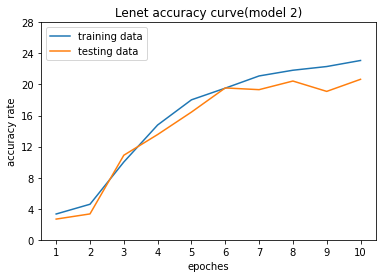

<Figure size 432x288 with 0 Axes>

In [26]:
# This shows the error rate of training and testing data after each epoch
df.index -= 1 
train_acc = df['error01_train'].T
test_acc = df['error01_test'].T
err_rate_list = np.array(err_rate_list).T
x = np.arange(epoches)
plt.xlabel('epoches')
plt.ylabel('accuracy rate')
plt.plot(train_acc)
plt.plot(test_acc)
plt.title("Lenet accuracy curve(model 2)", fontdict=None, loc='center')
plt.yticks(range(0, 30, 4))
plt.xticks(range(1, 11))
plt.legend(['training data', 'testing data'], loc='upper left')
plt.show()
plt.savefig('Lenet accuracy curve_model2.jpg')

Predict label: 39


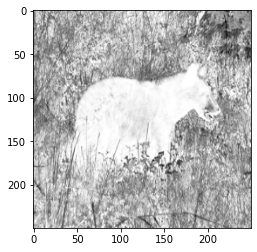

In [24]:
batch_image, batch_label, batch_label_ori = mydata.get_one_batch(0, label_tranform, normalize_mode)
# index = np.random.randint(500,size=1)
index = [285]
train_image_sample = batch_image[index,:,:,:] 
train_label_sample = batch_label_ori[index] # [label]
onehot_label_sample = batch_label[index] # [1, 50]
plt.imshow(train_image_sample[0,:,:,0], cmap=mpl.cm.Greys)
pred = ConvNet.Forward_Propagation(train_image_sample, onehot_label_sample, 'test')
print("Predict label:",pred[0])

Feature maps of C1


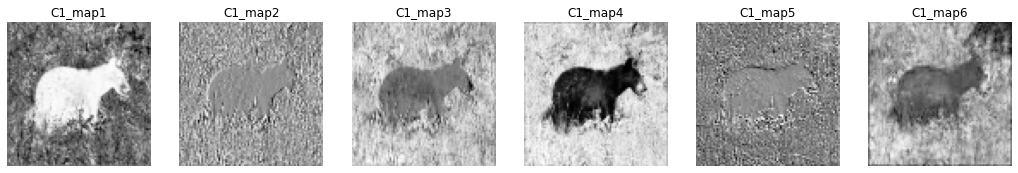

In [6]:
# Feature maps of C1
print("Feature maps of C1")
C1map = ConvNet.C1_FP[0]
fig, axarr = plt.subplots(1,6,figsize=(18,9))

for j in range(6):
    axarr[j].axis('off') 
    axarr[j].set_title( 'C1_map'+str(j+1))
    axarr[j].imshow(C1map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of a1


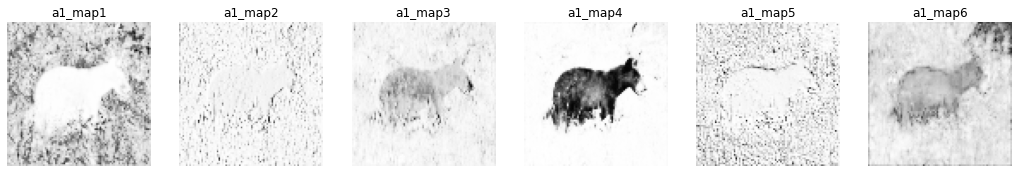

In [7]:
a1map = ConvNet.a1_FP[0]
print("Feature maps of a1")
fig, axarr = plt.subplots(1,6,figsize=(18,9))
for j in range(6):
    axarr[j].axis('off') 
    axarr[j].set_title( 'a1_map'+str(j+1))
    axarr[j].imshow(a1map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of S1


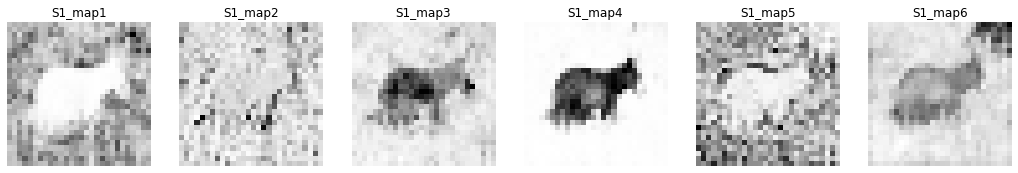

In [8]:
S1map = ConvNet.S1_FP[0]
print("Feature maps of S1")
# Feature maps of S1
fig, axarr = plt.subplots(1,6,figsize=(18,9))
for j in range(6):
    axarr[j].axis('off') 
    axarr[j].set_title( 'S1_map'+str(j+1))
    axarr[j].imshow(S1map[:,:,j], cmap=mpl.cm.Greys)

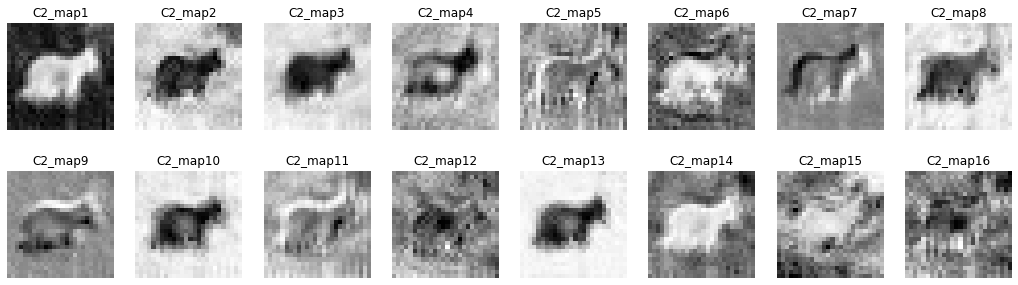

In [9]:
# Feature maps of C2
C2map = ConvNet.C2_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'C2_map'+str(j+1))
    axarr[x,y].imshow(C2map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of a2


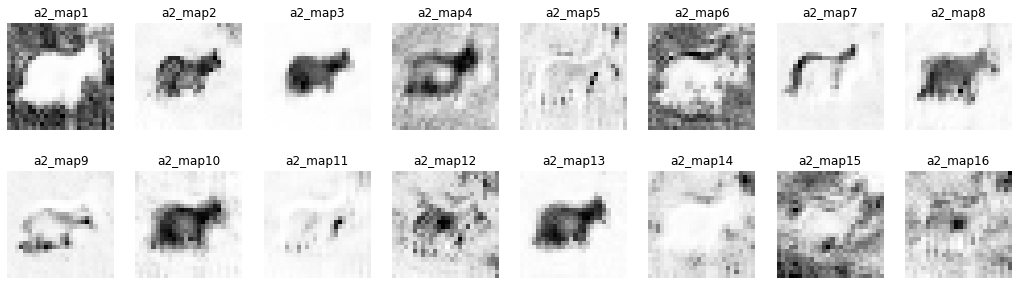

In [10]:
# Feature maps of a2
print("Feature maps of a2")
a2map = ConvNet.a2_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'a2_map'+str(j+1))
    axarr[x,y].imshow(a2map[:,:,j], cmap=mpl.cm.Greys)

Feature maps of S2


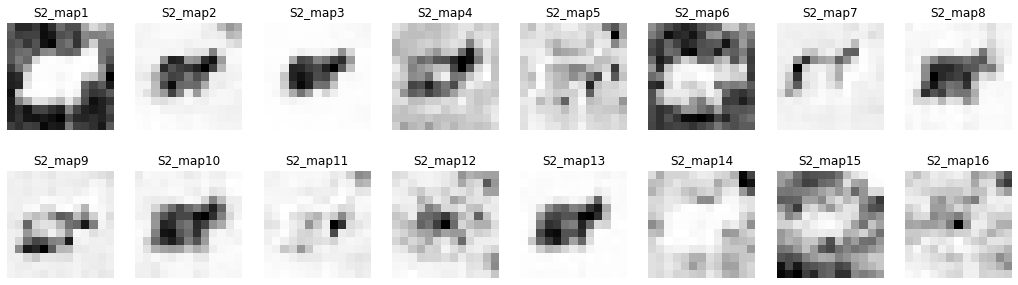

In [11]:
# Feature maps of S2
print("Feature maps of S2")
S2map = ConvNet.S2_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'S2_map'+str(j+1))
    axarr[x,y].imshow(S2map[:,:,j], cmap=mpl.cm.Greys)

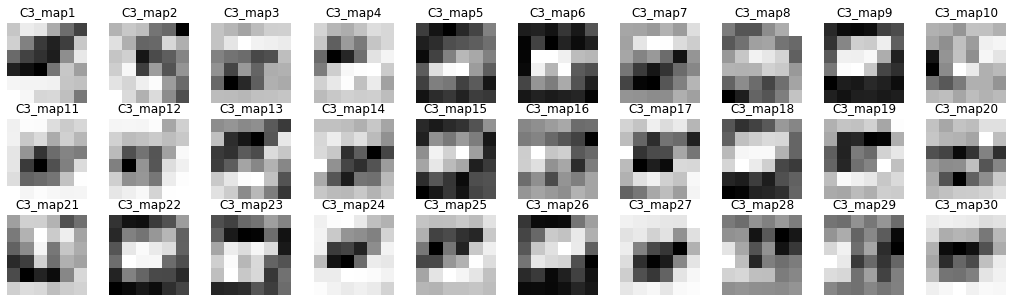

In [12]:
# Feature maps of C3
C3map = ConvNet.C3_FP[0]
fig, axarr = plt.subplots(3,10,figsize=(18,5))

for j in range(30):
    x,y = int(j/10), j%10
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'C3_map'+str(j+1))
    axarr[x,y].imshow(C3map[:,:,j], cmap=mpl.cm.Greys)

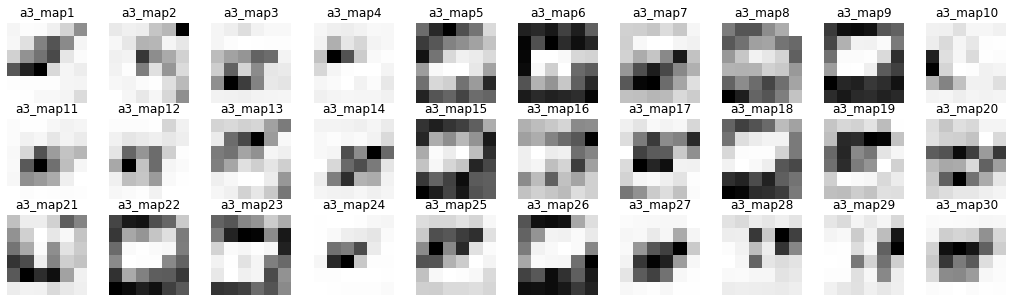

In [13]:
# Feature maps of a3
a3map = ConvNet.a3_FP[0]
fig, axarr = plt.subplots(3,10,figsize=(18,5))

for j in range(30):
    x,y = int(j/10), j%10
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'a3_map'+str(j+1))
    axarr[x,y].imshow(a3map[:,:,j], cmap=mpl.cm.Greys)

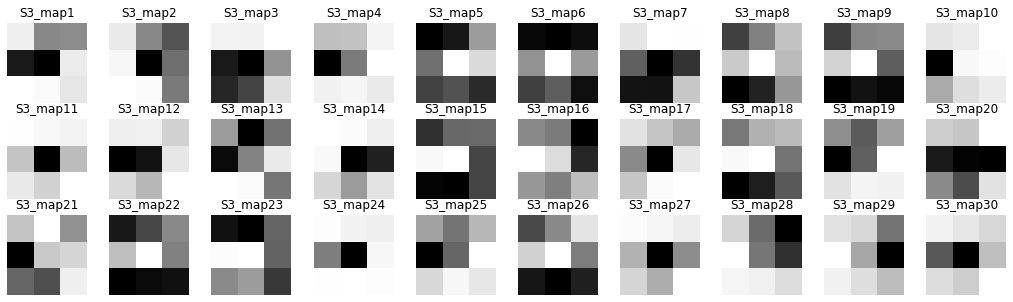

In [14]:
# Feature maps of s3
S3map = ConvNet.S3_FP[0]
fig, axarr = plt.subplots(3,10,figsize=(18,5))

for j in range(30):
    x,y = int(j/10), j%10
    axarr[x,y].axis('off') 
    axarr[x,y].set_title( 'S3_map'+str(j+1))
    axarr[x,y].imshow(S3map[:,:,j], cmap=mpl.cm.Greys)

In [15]:
# Feature maps of C5
print("Feature maps of C5")
C5map = (ConvNet.C5_FP[0])[0]
plt.figure(figsize=(20,10))
plt.axis('off') 
plt.imshow(C5map, cmap=mpl.cm.Greys)

Feature maps of C5


Feature maps of F7


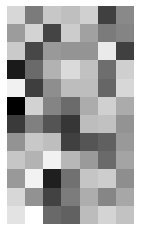

In [16]:
# Feature maps of F7
print("Feature maps of F7")
F7map = (ConvNet.F7_FP[0]).reshape(12,7) # size of F7 is n X 84
plt.axis('off') 
plt.imshow(F7map, cmap=mpl.cm.Greys)

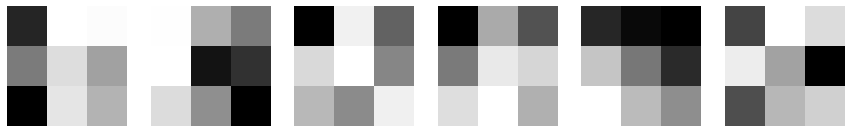

In [17]:
# The filters of C1
fig, axarr = plt.subplots(1,6,figsize=(15,15))
for i in range(6):
    axarr[i].axis('off')
    axarr[i].imshow(ConvNet.C1.weight[:,:,0,i], cmap=mpl.cm.Greys)

Feature maps of C1
Feature maps of S1
Feature maps of S2


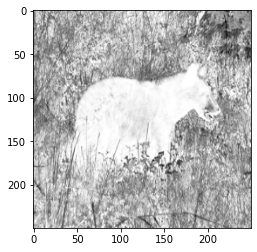

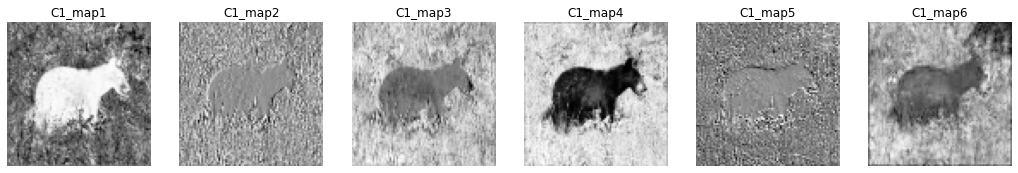

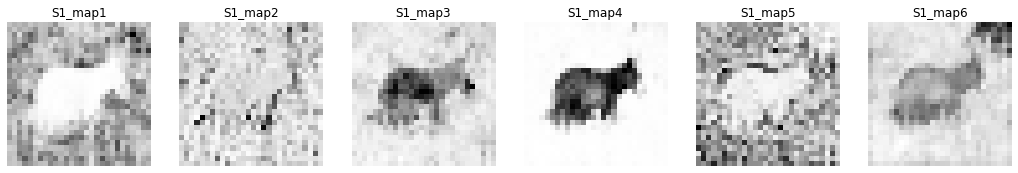

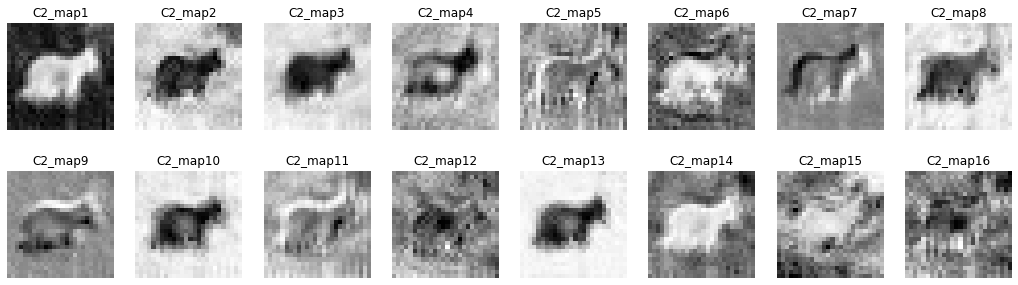

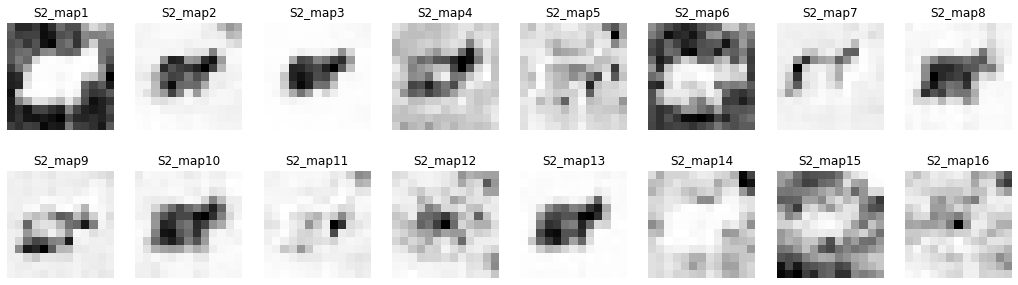

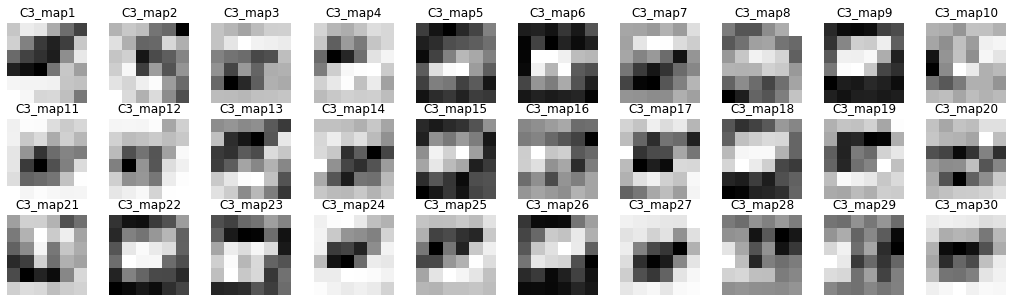

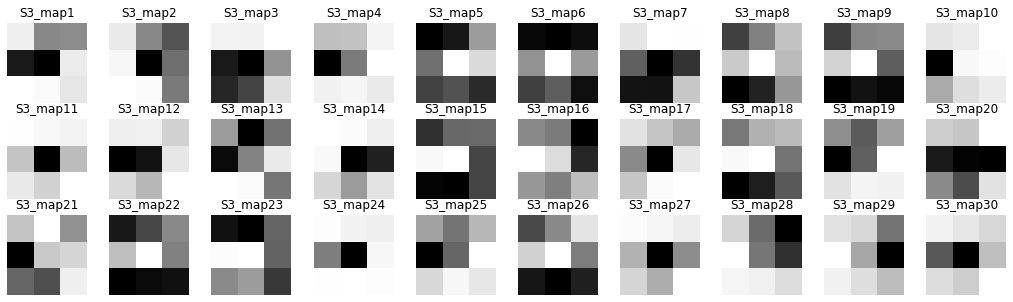

In [19]:
fm.save_feature_map(ConvNet, 10)